In [1]:
import numpy as np
import torch
from mcspace.model import MCSPACE
from mcspace.trainer import train_model
from mcspace.data_utils import get_data, get_mouse_diet_perturbations_dataset
from mcspace.utils import get_device, pickle_load, pickle_save,\
    estimate_process_variance, MODEL_FILE, DATA_FILE, \
    get_mcspace_cooccur_prob, get_sig_perturbation_diff_subset, \
    get_posterior_summary_data, get_pert_otu_sub, get_min_loss_path, apply_taxonomy_threshold, \
    get_summary_results, get_subj_averaged_assemblage_proportions
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from mcspace.dataset import DataSet
import pandas as pd

import ete3
from Bio import SeqIO, Phylo

import matplotlib.colors as mcolors
import mcspace.vis_tools as vis

import scipy.cluster.hierarchy as sch

In [2]:
# change font
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

# Paths

In [3]:
rootpath = Path("../../")
basepath = Path("./")
datapath = rootpath / "paper" / "datasets"

In [4]:
treepath = datapath / "mouse_experiments" / "output"
treefile = "newick_tree_query_reads.nhx"

In [5]:
respath = rootpath / "paper" / "results" / "analysis" / "Human"

In [6]:
outpath = basepath / "main_figures"
outpath.mkdir(exist_ok=True, parents=True)

# Load results

In [7]:
thetadf = pd.read_csv(respath / "assemblages.csv")
betadf = pd.read_csv(respath / "assemblage_proportions.csv", index_col=0)
# pertsdf = pd.read_csv(respath / "perturbation_bayes_factors.csv", index_col=0)
radf= pd.read_csv(respath / "relative_abundances.csv", index_col=0)

In [8]:
taxlevels = ['Otu', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']

In [9]:
taxonomy = thetadf[taxlevels].copy()

In [10]:
taxonomy = taxonomy.set_index("Otu")

In [11]:
thetadf = thetadf.set_index(taxlevels)

In [12]:
radf.columns = radf.columns.astype(int)

In [13]:
avebeta = get_subj_averaged_assemblage_proportions(betadf)

In [14]:
times = avebeta.index
subjects = ['H11']

# Plot full results

#### supplemental paper figure...

# Get most and least variable assemblages

In [15]:
beta = avebeta.T
beta['T-max'] = beta.max(axis=1)
beta['Mean'] = beta.mean(axis=1)
beta['Variance'] = np.log(beta).var(axis=1)
beta = beta.T

### least changed

In [16]:
persistent = beta.columns[beta.loc['Variance',:]<0.1]

In [17]:
# also cluster columns...
theta_persistent = np.log10(thetadf.loc[:,persistent] + 1e-20).values

data_matrix=theta_persistent.T
row_dist = sch.linkage(data_matrix, method='ward')
persist_row_order = sch.leaves_list(row_dist)

persistent = persistent[persist_row_order]
print(persistent)

Index(['A56', 'A61', 'A23', 'A22', 'A57', 'A15', 'A17', 'A27', 'A4'], dtype='object', name='Assemblage')


### variable assemblages

In [18]:
nx = 3

sigchanged = []
for aidx in beta.columns:
    temp = beta.loc[:,aidx]
    for day in times:
        rest = np.array([j for j in times if j != day])
        maxother = np.amax(temp[rest].values)
        current = temp[day]
        if current >= maxother*nx:
            sigchanged.append(aidx)
        
sigchanged = pd.Index(sigchanged)
print(sigchanged)

# cluster columns...
theta_var = np.log10(thetadf.loc[:,sigchanged] + 1e-20).values

data_matrix=theta_var.T
row_dist = sch.linkage(data_matrix, method='ward')
row_order = sch.leaves_list(row_dist)

sigchanged = sigchanged[row_order]
print(sigchanged)

Index(['A21', 'A38', 'A5', 'A51', 'A54', 'A60'], dtype='object')
Index(['A38', 'A5', 'A51', 'A60', 'A21', 'A54'], dtype='object')


### get taxa subset

In [19]:
otu_threshold = 0.01
betasub = list(set(persistent).union(set(sigchanged)))
otu_sub = thetadf.index[(thetadf.loc[:,betasub]>otu_threshold).any(axis=1)].get_level_values('Otu')

In [20]:
print(len(otu_sub))

45


#### compute z-scores

In [21]:
t = thetadf.values
b = avebeta.loc[:,thetadf.columns].values
print(t.shape)
print(b.shape)

(58, 69)
(5, 69)


In [22]:
z = (t - np.mean(t,axis=1,keepdims=True))/(np.std(t, axis=1, keepdims=True))

In [23]:
theta_zsparse2 = thetadf.copy()
theta_zsparse2[z<2] = 0

In [24]:
otu_sub_z2 = theta_zsparse2.index[(theta_zsparse2.loc[:,betasub]>otu_threshold).any(axis=1)].get_level_values('Otu')
notus = len(otu_sub_z2)
print(notus)

21


# Render figure

In [25]:
import matplotlib.patches as mpatches

In [26]:
# radf

In [27]:
ncomm_max = 50
notu_max = 80

tree_ratio = 0.1
gap_ratio = 0.2

ntime = len(times)
nsubj = len(subjects)

npert = len(persistent)
nvar = len(sigchanged)
ncomm = npert + nvar

# theta_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["white","green"])
theta_vmin=-3
theta_vmax=0
theta_cmap = mcolors.LinearSegmentedColormap.from_list('theta cmap', 
                                             [(0,    'white'),
                                              (0.25, 'lightyellow'),
                                              (0.5, 'yellowgreen'),
                                              (1,    'green')], N=256)
linewidth = 0.5
linecolor = '#e6e6e6'

In [28]:
colors = np.concatenate([sns.color_palette('muted', n_colors=10), sns.color_palette("dark", n_colors=10)])
familycolors = {x:y for x,y in zip(taxonomy['Family'].unique(),colors)}

original tree size: 1406
pruned tree size: 21


C:\Users\Gary\anaconda3\envs\mcfinal\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
C:\Users\Gary\anaconda3\envs\mcfinal\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


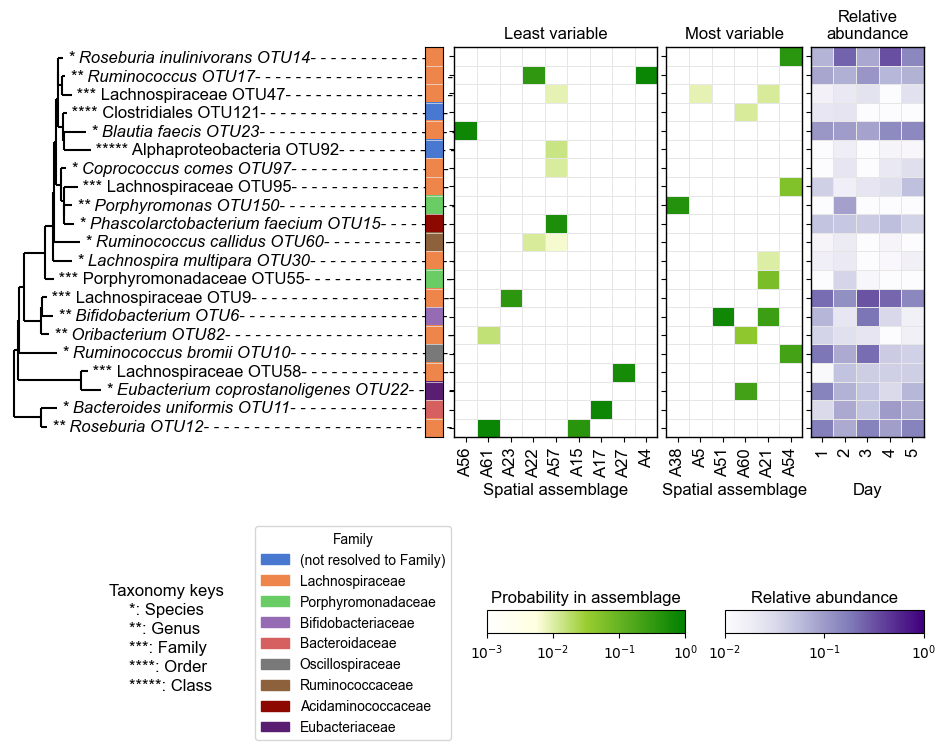

In [29]:
tree_ratio = 0.1
gap_ratio = 0.25

tree_text_len = 45
scale=2
tree_fontsize=12

# set aspect ratios
# add buffers so scales always same?
lgd_ratio = 0.05
lgd_gap = 0.1
hratios = [notus/notu_max, lgd_gap, lgd_ratio]
hratios.append(1.0 - (notus/notu_max)) # buffer?

# width ratios
wratios = [tree_ratio, gap_ratio, 1/ncomm_max,
           npert/ncomm_max, nvar/ncomm_max, ntime/ncomm_max,
           1.0-gap_ratio-tree_ratio-(ncomm/ncomm_max)]

# create figure
fig = plt.figure(figsize=(8.5*scale,11.5*scale))
gs = fig.add_gridspec(nrows=4,ncols=6+1,
                    height_ratios=hratios,
                      width_ratios=wratios,
                    wspace=0.05,
                     hspace=0.02)

# create subplots, get axes
ax_tree = fig.add_subplot(gs[0,0])

# squish to center lines...
squish_ratio = 0.01
squish_hspace = 0
gs_fam = gs[0,2].subgridspec(3,1, height_ratios=[squish_ratio,1,squish_ratio], hspace=squish_hspace)
ax_fam = fig.add_subplot(gs_fam[1,0])
gs_pert = gs[0,3].subgridspec(3,1, height_ratios=[squish_ratio,1,squish_ratio], hspace=squish_hspace)
ax_pert = fig.add_subplot(gs_pert[1,0])
gs_var = gs[0,4].subgridspec(3,1, height_ratios=[squish_ratio,1,squish_ratio], hspace=squish_hspace)
ax_var = fig.add_subplot(gs_var[1,0])
gs_ra = gs[0,5].subgridspec(3,1, height_ratios=[squish_ratio,1,squish_ratio], hspace=squish_hspace)
ax_ra = fig.add_subplot(gs_ra[1,0])


# # ax_sing = fig.add_subplot(gs[0,2])
# ax_fam = fig.add_subplot(gs[0,2])
# ax_pert = fig.add_subplot(gs[0,3])
# ax_var = fig.add_subplot(gs[0,4])
# ax_ra = fig.add_subplot(gs[0,5])

# for legend...
gs_lgd = gs[-2,:-1].subgridspec(3,4)
ax_taxa_lgd = fig.add_subplot(gs_lgd[:,0])
ax_theta_lgd = fig.add_subplot(gs_lgd[0,2])
ax_ra_lgd = fig.add_subplot(gs_lgd[0,3])
ax_fam_lgd = fig.add_subplot(gs_lgd[:,1])


# plot tree
taxa = taxonomy.reset_index().copy()
taxa = taxa.set_index("Otu")
taxa_subset = taxa.loc[otu_sub_z2,:]
tree = vis.get_pruned_tree(treepath, treefile, taxa_subset, temppath=Path("./_tmp_sub"), upper=False)
ax_tree, otu_order = vis.plot_phylo_tree(ax_tree, tree, taxonomy, fontsize=tree_fontsize, text_len=tree_text_len)

# plot family annotation
ntaxa = len(otu_order)
pcolors = np.zeros((ntaxa,1,3))
for i,x in enumerate(taxonomy.loc[otu_order,'Family']):
    pcolors[i,0,:] = familycolors[x]
ax_fam.imshow(pcolors) #,linewidth=linewidth, linecolor=linecolor) #, aspect='equal')
# ax.set_xticks(np.arange(0, ntaxa, 1))
ax_fam.set_yticks(np.arange(0, ntaxa, 1))
# # Minor ticks
# ax_fam.set_xticks(np.arange(-.5, ntaxa, 1), minor=True)
ax_fam.set_yticks(np.arange(-.5, ntaxa, 1), minor=True)
ax_fam.grid(which='minor', color=linecolor, linestyle='-', linewidth=linewidth)
ax_fam.set_xticklabels("")
ax_fam.set_yticklabels("")
ax_fam.tick_params('both', length=0, width=0, which='both')

# plot assemblages
ax_thetas = [ax_pert, ax_var]
bsub = [persistent, sigchanged]
for comm_order, ax_theta in zip(bsub, ax_thetas):
    thetadf2 = theta_zsparse2.copy()
#     thetadf2[thetadf2<otu_threshold] = 0
    theta_plot = np.log10(thetadf2.loc[otu_order,comm_order])
    ax_theta=sns.heatmap(theta_plot, ax=ax_theta, cmap=theta_cmap, square=False, cbar=False, vmin=theta_vmin, vmax=theta_vmax, 
                         linewidth=linewidth, linecolor=linecolor, xticklabels=True, yticklabels=True) #True)
    # ax_theta.set_xticklabels([f"A{i+1}" for i in range(len(beta_keep))], rotation=90, fontsize=tree_fontsize)
    ax_theta.set_yticklabels("")
    ax_theta.set_xticklabels(ax_theta.get_xticklabels(), fontsize=tree_fontsize, rotation=90)
    ax_theta.set_xlabel("Spatial assemblage", fontsize=tree_fontsize)
    ax_theta.set_ylabel("")
    ax_theta=vis.add_border(ax_theta)
ax_pert.set_title("Least variable", fontsize=tree_fontsize)
ax_var.set_title("Most variable", fontsize=tree_fontsize)

# plot relative abundances
ax_ra=sns.heatmap(np.log10(radf.loc[otu_order,times]), cmap='Purples', vmin=-2.5, vmax=-0.5,ax=ax_ra,
                   linewidth=linewidth, linecolor=linecolor, xticklabels=True, yticklabels=True, cbar=False)
ax_ra = vis.add_border(ax_ra)
ax_ra.set_yticklabels("")
ax_ra.set_ylabel("")
ax_ra.set_xlabel("Day", fontsize=tree_fontsize)
ax_ra.set_xticklabels(ax_ra.get_xticklabels(), rotation=90, fontsize=tree_fontsize)
ax_ra.set_title("Relative\nabundance", fontsize=tree_fontsize)


# plot legend...
# plot legend
norm = mpl.colors.Normalize(vmin=theta_vmin, vmax=theta_vmax)
ax_theta_lgd=mpl.colorbar.ColorbarBase(ax_theta_lgd, cmap=theta_cmap, norm=norm, orientation='horizontal')
ax_theta_lgd.ax.set_xticks([0,-1,-2,-3])
ax_theta_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$',r'$10^{-3}$'])
ax_theta_lgd.ax.set_title("Probability in assemblage")

norm = mpl.colors.Normalize(vmin=-2, vmax=0)
ax_ra_lgd=mpl.colorbar.ColorbarBase(ax_ra_lgd, cmap="Purples", norm=norm, orientation='horizontal')
ax_ra_lgd.ax.set_xticks([0,-1,-2])
ax_ra_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_ra_lgd.ax.set_title("Relative abundance")


lgd_xpos=0.5
lgd_ypos=1.2
indent_xpos=lgd_xpos+0.1
dy=0.25
lgd_fontsize=12

levels = ['Species','Genus', 'Family', 'Order', 'Class'] #, 'Phylum', 'Kingdom']      
level_dict = {'Species': '*', 'Genus': '**', 'Family': '***', 'Order': '****', 'Class': '*****'} #, 'Phylum': '******', 'Kingdom': '*******'}

fig.align_xlabels([ax_pert, ax_var, ax_ra])

ax_taxa_lgd.text(lgd_xpos,lgd_ypos,"Taxonomy keys", fontsize=lgd_fontsize)
for i,level in enumerate(levels):
    ax_taxa_lgd.text(indent_xpos, lgd_ypos - (i+1)*dy, f"{level_dict[level]}: {level}", fontsize=lgd_fontsize)
ax_taxa_lgd=vis.remove_border(ax_taxa_lgd)

plotfams = taxonomy.loc[otu_sub_z2,'Family'].unique()
patches = []
for f in plotfams:
    if f == 'na':
        flab = '(not resolved to Family)'
    else:
        flab = f
    patches.append(mpatches.Patch(color=familycolors[f], label=flab))
ax_fam_lgd.legend(handles=patches, title="Family", loc='upper left', bbox_to_anchor=(0,2.2))
ax_fam_lgd=vis.remove_border(ax_fam_lgd)

plt.savefig(outpath / "human_variable_nonvariable_assemblages.svg", bbox_inches="tight")